# Start: Analysiere Daten

In [82]:
# import initial_data.csv
import pandas as pd
import numpy as np

from feasibility import is_feasible

# import data from csv file
def import_data():
    data = pd.read_csv('initial_data.csv')
    return data

data = import_data()

In [83]:
# put column names into a list
column_names = data.columns.values
print(column_names)
inputs = column_names[0:8]
print(inputs)
outputs = column_names[8:13]
print(outputs)

['Engine speed' 'Engine load' 'Railpressure' 'Air supply' 'Crank angle'
 'Intake pressure' 'Back pressure' 'Intake temperature' 'NOx' 'PM 1' 'CO2'
 'PM 2' 'Pressure cylinder']
['Engine speed' 'Engine load' 'Railpressure' 'Air supply' 'Crank angle'
 'Intake pressure' 'Back pressure' 'Intake temperature']
['NOx' 'PM 1' 'CO2' 'PM 2' 'Pressure cylinder']


In [84]:
def get_input_data(data, row):
    x1, x2, x3, x4, x5, x6, x7, x8 = data.iloc[row, 0], data.iloc[row, 1], data.iloc[row, 2], data.iloc[row, 3], data.iloc[row, 4], data.iloc[row, 5], data.iloc[row, 6], data.iloc[row, 7]
    return x1, x2, x3, x4, x5, x6, x7, x8

def get_output_data(row):
    x1, x2, x3, x4, x5 = data.iloc[row, 8], data.iloc[row, 9], data.iloc[row, 10], data.iloc[row, 11], data.iloc[row, 12]
    return x1, x2, x3, x4, x5

def get_critical_output_data(i):
    x1, x2, x3 = data.iloc[i, 9], data.iloc[i, 11], data.iloc[i, 12]
    return x1, x2, x3

In [85]:
# show if data row is feasible via the first 8 columns and the function is_feasible
feasible = []
for i in range(len(data)):
    x1, x2, x3, x4, x5, x6, x7, x8 = get_input_data(data, i)
    # print(x1, x2, x3, x4, x5, x6, x7, x8)
    feasible.append(is_feasible(x1, x2, x3, x4, x5, x6, x7, x8))
data['feasible'] = feasible

In [86]:
# Check if outputs are in safe range
# PM 1 < 6, PM 2 < 16, Pressure cylinder < 160

def label_safe(data):
    safe = []
    for i in range(len(data)):
        x9, x10, x11 = get_critical_output_data(i)
        if x9 < 6 and x10 < 16:
            if x11 < 160:
                safe.append(0)
            else:
                safe.append(2)
        else:
            if x11 < 160:
                safe.append(1)
            else:
                safe.append(2)
    data['safe'] = safe
    return data

data = label_safe(data)

In [87]:
unsafe_params = [5, 13, 130]

# label broader safe range
def label_broader_safe(data):
    safe = []
    for i in range(len(data)):
        x9, x10, x11 = get_critical_output_data(i)
        if x9 < unsafe_params[0] and x10 < unsafe_params[1]:
            if x11 < unsafe_params[2]:
                safe.append(0)
            else:
                safe.append(2)
        else:
            if x11 < unsafe_params[2]:
                safe.append(1)
            else:
                safe.append(2)
    data['broader_safe'] = safe
    return data

data = label_broader_safe(data)

# count number of False values in safe column
print((len(data[data['broader_safe'] == 1])+len(data[data['broader_safe'] == 2])))

12


In [88]:
# show unsafe data (safe == 1 or safe == 2)
unsafe_data = data[(data['broader_safe'] == 1) | (data['broader_safe'] == 2)]
print(unsafe_data)

    Engine speed  Engine load  Railpressure  Air supply  Crank angle  \
39        1300.0        64.88        1798.9    297.1093        -2.89   
46        1400.0        73.39        1887.8    358.3535        -3.64   
62        1600.0       135.17        2195.4    740.8542         1.39   
68        1700.0       135.93        2298.3    793.9227         2.31   
70        1800.0        35.66        1521.7    310.5600         5.69   
74        1800.0       122.01        2401.4    787.3758         2.40   
75        1800.0       145.02        2378.4    885.3311         2.72   
81        1900.0       115.29        2499.3    800.7886         3.08   
82        1900.0       138.39        2499.3    922.4504         2.94   
88        2000.0       116.28        2499.9    875.2752         3.49   
89        2000.0       139.54        2500.3   1008.3008         3.66   
95        2100.0       124.97        2500.1   1010.2031         4.27   

    Intake pressure  Back pressure  Intake temperature         

In [89]:
# train a model to predict unsafe output
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# split data into training and testing data
X = data[inputs]
y = data['broader_safe']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# count number of False values in y_train and y_test
print("Number of unsafe in training: ",(len(y_train[y_train == 1])+len(y_train[y_train == 2])))
print("Number of unsafe in testing: ",(len(y_test[y_test == 1])+len(y_test[y_test == 2])))

print("Parameters for unsafe data: ")
print("PM 1: ", unsafe_params[0])
print("PM 2: ", unsafe_params[1])
print("Pressure cylinder: ", unsafe_params[2])

# train a random forest classifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

# predict on test data
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Number of unsafe in training:  10
Number of unsafe in testing:  2
Parameters for unsafe data: 
PM 1:  5
PM 2:  13
Pressure cylinder:  130
Accuracy: 0.9


In [90]:
# submission.csv
def import_submission():
    submission = pd.read_csv('submission.csv')
    return submission

submission = import_submission()

In [91]:
# show if data row is feasible via the first 8 columns and the function is_feasible
feasible = []
for i in range(len(submission)):
    x1, x2, x3, x4, x5, x6, x7, x8 = get_input_data(submission,i)
    # print(x1, x2, x3, x4, x5, x6, x7, x8)
    feasible.append(is_feasible(x1, x2, x3, x4, x5, x6, x7, x8))
submission['feasible'] = feasible

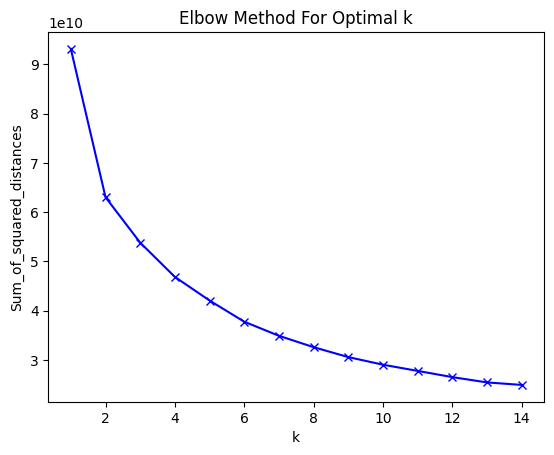

In [92]:
# find the area with the most data points via k-means clustering
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# find number of clusters via elbow method
Sum_of_squared_distances = []
K = range(1, 15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(submission)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


In [93]:
# k-Means Clustering durchführen
kmeans = KMeans(n_clusters=6)  # s.o.: 6 Cluster
kmeans.fit(submission)
labels = kmeans.labels_

# Format of print without exponential
np.set_printoptions(suppress=True)

# Größten Cluster finden
# unique, counts = np.unique(labels, return_counts=True)
# groesster_cluster_index = np.argmax(counts)
# groesster_cluster = submission[labels == groesster_cluster_index]

# Bereich des größten Clusters bestimmen (durch Mittelpunkt und Streuung)
# mittelpunkt = kmeans.cluster_centers_[groesster_cluster_index]
# max_distanz = np.max(np.sqrt(np.sum((groesster_cluster - mittelpunkt)**2, axis=1)))

# print(f"Mittelpunkt des größten Clusters: {mittelpunkt}")
# print(f"Maximale Distanz vom Mittelpunkt: {max_distanz}")

# Größe aller Cluster ausgeben mit deren Mittelpunkt und Streuung
allClusters = []
for i in range(6):
    cluster = submission[labels == i]
    mittelpunkt = kmeans.cluster_centers_[i]
    streuung = np.max(np.sqrt(np.sum((cluster - mittelpunkt)**2, axis=1)))
    # get the ranges of the clusters
    min_value = np.min(cluster, axis=0)
    max_value = np.max(cluster, axis=0)
    # calculate the mean and std of each attribute in the cluster
    print(f"Cluster {i}:")
    means = []
    stds = []
    for j in range(8):
        means.append(np.mean(cluster.iloc[:, j]))
        stds.append(np.std(cluster.iloc[:, j]))
        # print(f"Attribute {j}: Mittelwert: {np.mean(cluster.iloc[:, j])}, Standardabweichung: {np.std(cluster.iloc[:, j])}")
    allClusters.append((i, cluster, len(cluster), mittelpunkt, streuung, min_value, max_value, means, stds))
    # print(cluster)
    print(f"Cluster {i}: {len(cluster)} Datenpunkte, Mittelpunkt: {mittelpunkt}, Streuung: {streuung}, Min: + Max: (Range), Mittelwerte, Standardabweichungen")

Cluster 0:
Cluster 0: 9078 Datenpunkte, Mittelpunkt: [1871.15423532   73.04879044 2056.13600105  718.75330968    0.70905565
 2096.53042976 3338.80657337   58.23093827    1.        ], Streuung: 1458.3121391662773, Min: + Max: (Range), Mittelwerte, Standardabweichungen
Cluster 1:
Cluster 1: 9076 Datenpunkte, Mittelpunkt: [1232.33604338   51.68290167 1232.66129083  473.56377668   -0.48883963
 1490.35497853 1726.21372591   56.16136435    1.        ], Streuung: 1473.4653243161833, Min: + Max: (Range), Mittelwerte, Standardabweichungen
Cluster 2:
Cluster 2: 10013 Datenpunkte, Mittelpunkt: [1224.16777645   54.83142515 1211.31036147  471.25934029   -0.52242411
 1523.24503142 3216.81063416   56.17949442    1.        ], Streuung: 1469.389202366113, Min: + Max: (Range), Mittelwerte, Standardabweichungen
Cluster 3:
Cluster 3: 10197 Datenpunkte, Mittelpunkt: [1868.56583486   70.21616832 2006.68381388  713.75983951    0.68412177
 2154.59919523 1955.0453364    58.08138911    1.        ], Streuung: 15

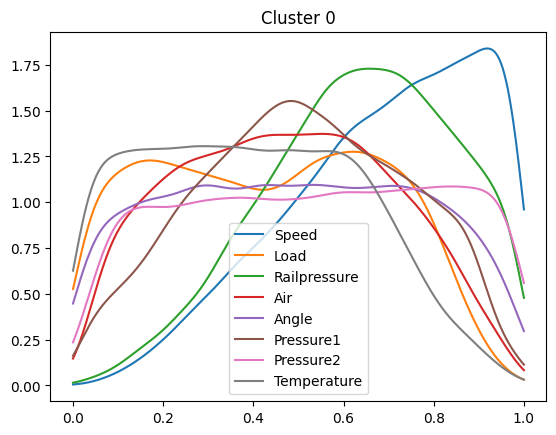

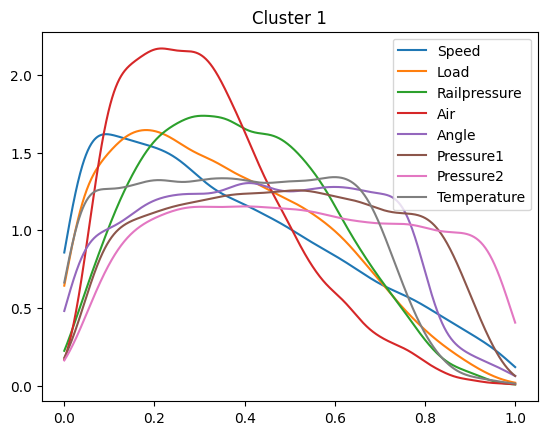

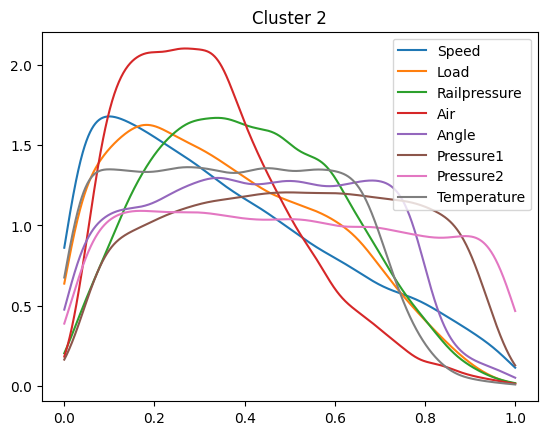

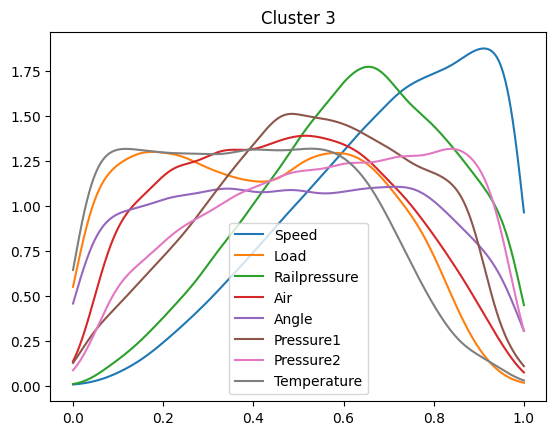

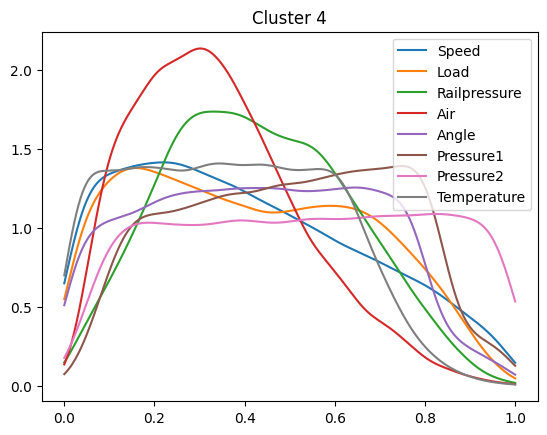

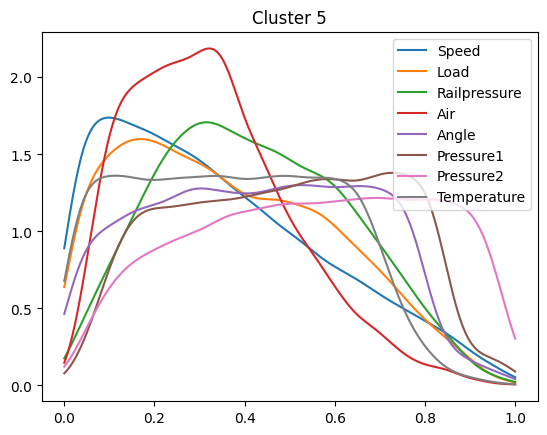

In [94]:
# normalize the cluster data in each cluster
normalizedClusters = []
for i in range(6):
    cluster = allClusters[i][1]
    # cluster drop last column (Type bool)
    cluster = cluster.drop(columns=['feasible'])
    min_value = allClusters[i][5]
    max_value = allClusters[i][6]
    for index, row in cluster.iterrows():
        for col in cluster.columns:  # Verwenden Sie die Spaltennamen direkt
            #print(type(row[col]))
            cluster.at[index, col] = (row[col] - min_value[col]) / (max_value[col] - min_value[col])
    normalizedClusters.append(cluster)

from scipy.stats import gaussian_kde

for j in range(6):
    # KDE-Instanz erstellen für jeden normalisierten Cluster
    cluster = normalizedClusters[j]
    
    # get the column names
    column_names = cluster.columns.values

    kdes = []
    densities = []
    values = np.linspace(0, 1, 1000)
    for i in range(8):
        kde = gaussian_kde(cluster.iloc[:, i])
        kdes.append(kde)
        densities.append(kde.evaluate(values))

    # Dichtefunktionen für die normalisierten Werte plotten
    for i in range(8):
        plt.plot(values, densities[i], label=cluster.columns.values[i])
        plt.title(f"Cluster {j}")
    plt.legend()
    plt.show()




In [95]:
# generate random data points in the range of the largest cluster
# import random
# random_data = []
# for i in range(10):
#     random_data.append([
#         random.uniform(groesster_cluster.min()[0], groesster_cluster.max()[0]),
#         random.uniform(groesster_cluster.min()[1], groesster_cluster.max()[1]),
#         random.uniform(groesster_cluster.min()[2], groesster_cluster.max()[2]),
#         random.uniform(groesster_cluster.min()[3], groesster_cluster.max()[3]),
#         random.uniform(groesster_cluster.min()[4], groesster_cluster.max()[4]),
#         random.uniform(groesster_cluster.min()[5], groesster_cluster.max()[5]),
#         random.uniform(groesster_cluster.min()[6], groesster_cluster.max()[6]),
#         random.uniform(groesster_cluster.min()[7], groesster_cluster.max()[7])
#     ])
# print(random_data)

In [96]:
# # predict safe or unsafe for the cluster center
# print(clf.predict([mittelpunkt])) # 0 means safe, 1 means semi-safe, 2 means dangerous--> 0

# # predict safe or unsafe for the random data points
# print(clf.predict(random_data)) # True means safe, False means unsafe --> True